In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements

In [3]:
# using Revise
using BAT 

In [4]:
conv_mat = load("../data/experiment/dataset_2/m2/conv_matrix.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"],
)

(cam_1 = [0.16922280747049184 0.14725876292577664 … 9.804539409837765e-19 9.91744496519356e-19; 0.13698894345024634 0.12178663702930428 … 9.52516847848642e-19 9.559768551032814e-19; … ; 3.392849462608846e-8 3.527635033404157e-8 … 0.06746695270012963 0.06747823881205484; 3.392849462607551e-8 3.527635033402785e-8 … 0.07032651372714573 0.07033882138934304], cam_2 = [0.2489166139447179 0.22131578631138504 … 2.660536939905101e-19 2.416060283321948e-19; 0.19738388190897505 0.1792450446630506 … 2.683303555266501e-19 2.4407251042449397e-19; … ; 6.893366827562823e-5 5.917531632521968e-5 … 0.06742289307540646 0.06743419376894891; 9.06994723790053e-5 7.783372485099013e-5 … 0.07027846175518433 0.0702907845309871], cam_3 = [0.12876476555810015 0.11096323591192903 … 9.114644254616891e-19 8.462095254466114e-19; 0.10510231890436048 0.09253546225811259 … 9.511992741342331e-19 9.04229043901602e-19; … ; 3.3471334001937267e-8 3.44507918466309e-8 … 0.06749057222978075 0.06750185016109878; 3.347133400192821

In [5]:
# Experiment Event: 

images = load("../data/experiment/dataset_2/m2/images.jld2");

event_number = 2

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
)

data = event.cam_4;

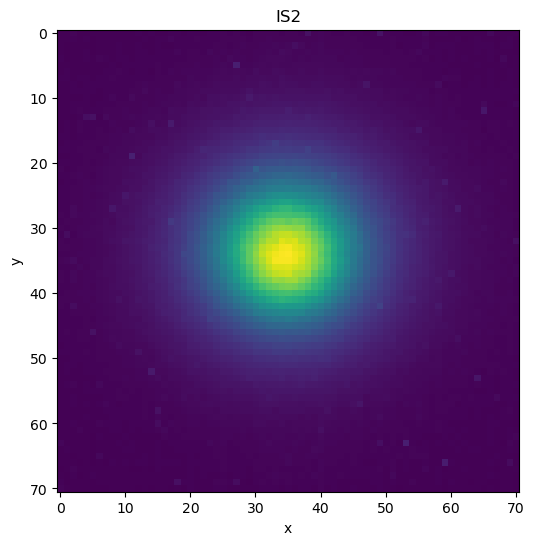

PyObject Text(0.5, 1.0, 'IS2')

In [6]:
img, ax = plt.subplots(1,1, figsize=(6,6))

ax.imshow(data)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("IS2")

# Fit 1 (Chi-Squared cost): 

In [7]:
prior = NamedTupleDist(
    μ_x = 20 .. 50,
    μ_y = 20 .. 50,
    σ_x = 3 .. 20,
    σ_y = 3 .. 20,
    i = 1 .. 2^20
    );

In [8]:
log_likelihood = let data = data
    
    params -> begin
        
        image_matrix = zeros(Float64, size(data)...)
        
        for pix_ind in CartesianIndices(image_matrix)
    
            x_edge = pix_ind.I[1] 
            y_edge = pix_ind.I[2] 

            pix_prediction::Float64 = cdf(Normal(params.μ_x,params.σ_x), x_edge) - cdf(Normal(params.μ_x,params.σ_x), x_edge - 1)
            pix_prediction *= cdf(Normal(params.μ_y,params.σ_y), y_edge) - cdf(Normal(params.μ_y,params.σ_y), y_edge - 1)

            pix_prediction = pix_prediction*params.i
            image_matrix[pix_ind] = pix_prediction
        end
        
        log_sq = sum(-(data - image_matrix).^2)

    
        return LogDVal(log_sq)
        
    end
end

#1 (generic function with 1 method)

In [9]:
posterior = PosteriorDensity(log_likelihood, prior);
algorithm = MetropolisHastings()

nsamples = 10^4
nchains = 4

@time samples = bat_sample(posterior, (nsamples, nchains), algorithm,
        max_nsteps = 10^4, max_time = 15, 
    ).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 71.494019 seconds (38.09 M allocations: 23.833 GiB, 8.79% gc time)


In [10]:
mode_params = mode(samples)[1]

(μ_x = 34.121132796170514, μ_y = 35.153267846882294, σ_x = 8.674729166133224, σ_y = 9.04573111042253, i = 880282.1695218802)

In [11]:
image_reconstructed = zeros(Float64, size(data)...)

for pix_ind in CartesianIndices(image_reconstructed)
    
    x_edge = pix_ind.I[1] 
    y_edge = pix_ind.I[2] 

    pix_prediction::Float64 = cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge) - cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge - 1)
    pix_prediction *= cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge) - cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge - 1)

    pix_prediction = pix_prediction*mode_params.i
    image_reconstructed[pix_ind] = pix_prediction
end

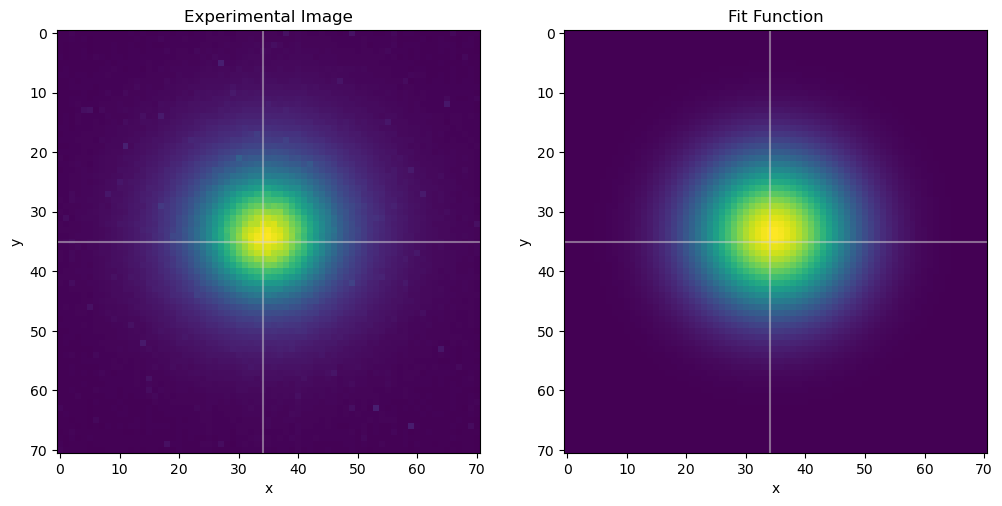

PyObject Text(0.5, 1.0, 'Fit Function')

In [12]:
img, (ax, ax2) = plt.subplots(1,2, figsize=(12,6))

ax.imshow(data)

ax.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax2.imshow(image_reconstructed)

ax2.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax2.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Experimental Image")

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Fit Function")

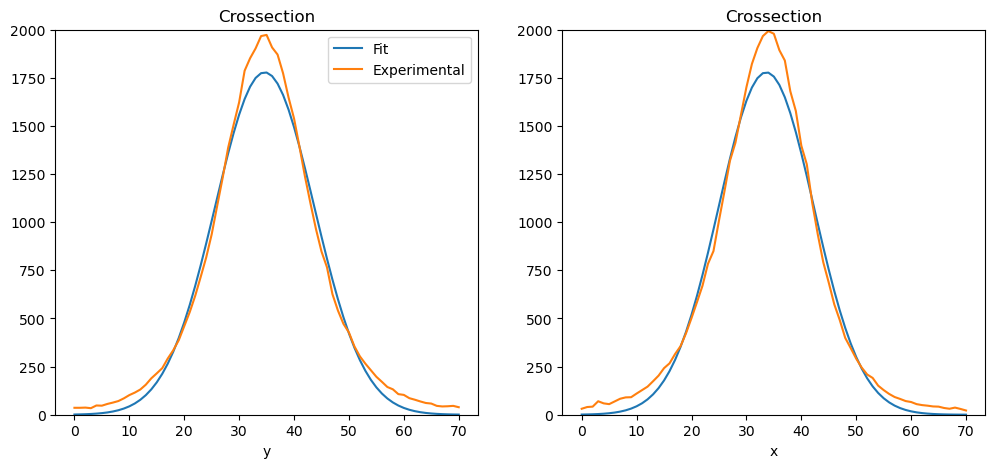

(0.0, 2000.0)

In [13]:
x = round(Int64, mode_params.μ_x)
y = round(Int64, mode_params.μ_y)

img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(image_reconstructed[x, :], label="Fit")
ax[1].plot(data[x, :], label="Experimental")
ax[1].legend()

ax[1].set_xlabel("y")
ax[1].set_title("Crossection")

ax[2].set_xlabel("x")
ax[2].set_title("Crossection")

ax[2].plot(image_reconstructed[:, y])
ax[2].plot(event.cam_4[:, y])

ax[1].set_ylim(0,2000)
ax[2].set_ylim(0,2000)

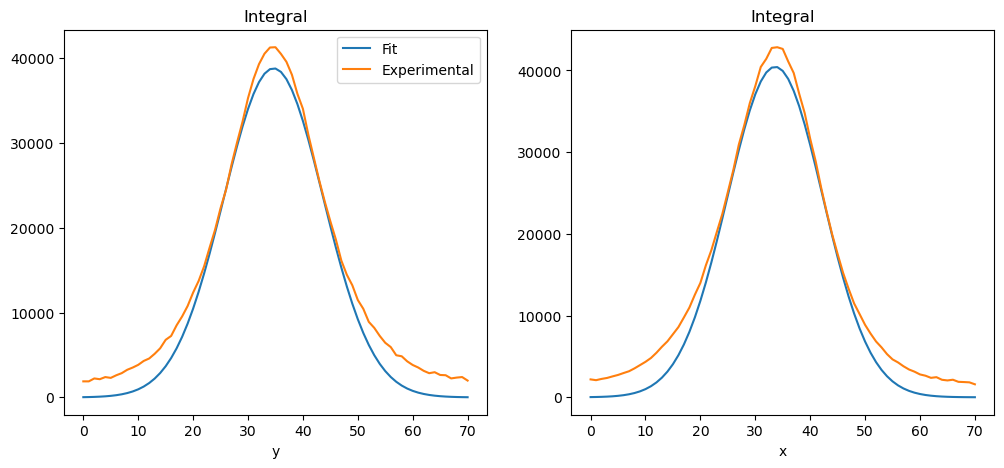

PyObject Text(0.5, 1.0, 'Integral')

In [14]:
img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(sum(image_reconstructed, dims=1)[1,:], label="Fit")
ax[1].plot(sum(data, dims=1)[1,:], label="Experimental")

ax[1].legend()

ax[2].plot(sum(image_reconstructed, dims=2))
ax[2].plot(sum(event.cam_4, dims=2))

ax[1].set_xlabel("y")
ax[1].set_title("Integral")

ax[2].set_xlabel("x")
ax[2].set_title("Integral")

# Fit 1-b (Chi-Squared cost + pedestal): 

In [63]:
prior = NamedTupleDist(
    μ_x = 20 .. 50,
    μ_y = 20 .. 50,
    σ_x = 3 .. 20,
    σ_y = 3 .. 20,
    i = 1 .. 2^20,
    b = 0 .. 100
    );

In [64]:
log_likelihood = let data = data
    
    params -> begin
        
        image_matrix = zeros(Float64, size(data)...)
        
        for pix_ind in CartesianIndices(image_matrix)
    
            x_edge = pix_ind.I[1] 
            y_edge = pix_ind.I[2] 

            pix_prediction::Float64 = cdf(Normal(params.μ_x,params.σ_x), x_edge) - cdf(Normal(params.μ_x,params.σ_x), x_edge - 1)
            pix_prediction *= cdf(Normal(params.μ_y,params.σ_y), y_edge) - cdf(Normal(params.μ_y,params.σ_y), y_edge - 1)

            pix_prediction = pix_prediction*params.i + params.b
            image_matrix[pix_ind] = pix_prediction
        end
        
        log_sq = sum(-(data - image_matrix).^2)

    
        return LogDVal(log_sq)
        
    end
end

#15 (generic function with 1 method)

In [65]:
posterior = PosteriorDensity(log_likelihood, prior);
algorithm = MetropolisHastings()

nsamples = 10^4
nchains = 4

@time samples = bat_sample(posterior, (nsamples, nchains), algorithm,
        max_nsteps = 10^4, max_time = 15, 
    ).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 51.888395 seconds (7.90 M allocations: 22.487 GiB, 11.50% gc time)


In [66]:
mode_params = mode(samples)[1]

(μ_x = 34.145967132427565, μ_y = 35.14622188466227, σ_x = 8.13693044560105, σ_y = 8.480179190865107, i = 782528.0957193914, b = 47.99801257863353)

In [67]:
image_reconstructed = zeros(Float64, size(data)...)

for pix_ind in CartesianIndices(image_reconstructed)
    
    x_edge = pix_ind.I[1] 
    y_edge = pix_ind.I[2] 

    pix_prediction::Float64 = cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge) - cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge - 1)
    pix_prediction *= cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge) - cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge - 1)

    pix_prediction = pix_prediction*mode_params.i + mode_params.b
    image_reconstructed[pix_ind] = pix_prediction
end

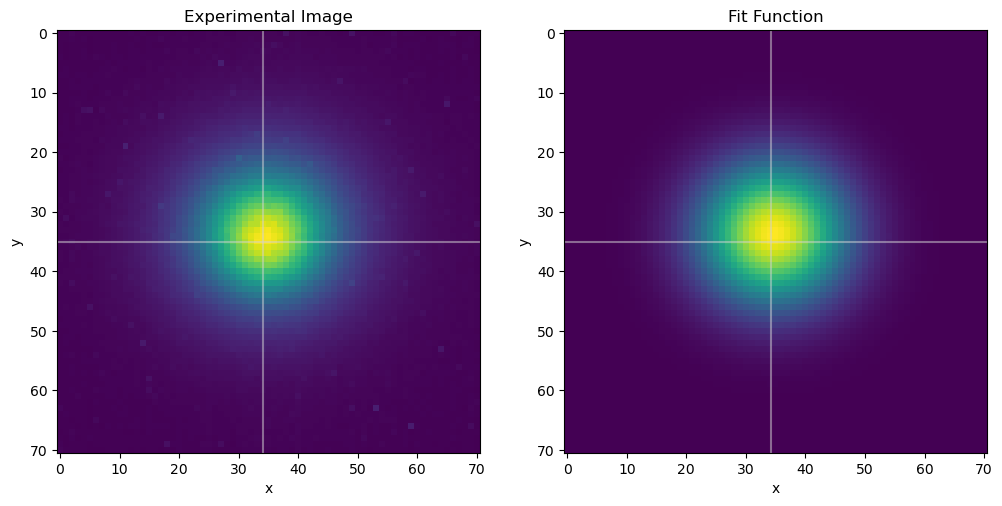

PyObject Text(0.5, 1.0, 'Fit Function')

In [68]:
img, (ax, ax2) = plt.subplots(1,2, figsize=(12,6))

ax.imshow(data)

ax.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax2.imshow(image_reconstructed)

ax2.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax2.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Experimental Image")

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Fit Function")

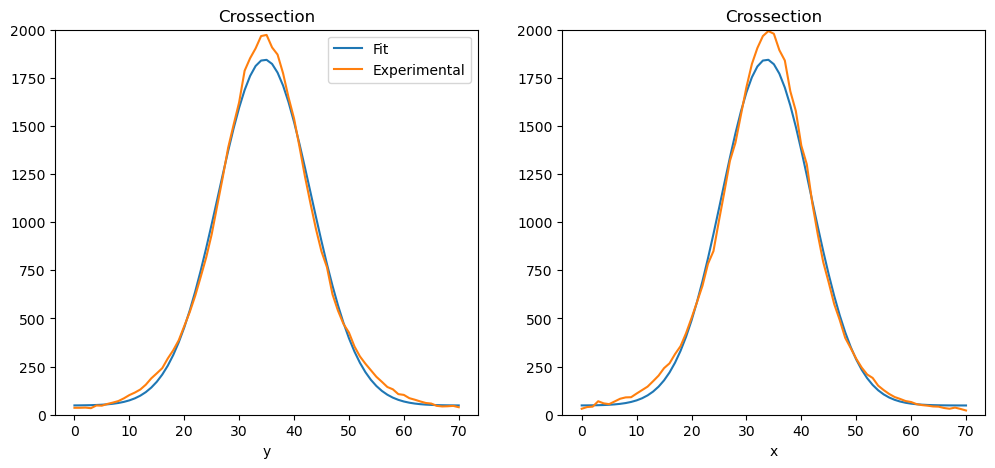

(0.0, 2000.0)

In [69]:
x = round(Int64, mode_params.μ_x)
y = round(Int64, mode_params.μ_y)

img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(image_reconstructed[x, :], label="Fit")
ax[1].plot(data[x, :], label="Experimental")
ax[1].legend()

ax[1].set_xlabel("y")
ax[1].set_title("Crossection")

ax[2].set_xlabel("x")
ax[2].set_title("Crossection")

ax[2].plot(image_reconstructed[:, y])
ax[2].plot(event.cam_4[:, y])

ax[1].set_ylim(0,2000)
ax[2].set_ylim(0,2000)

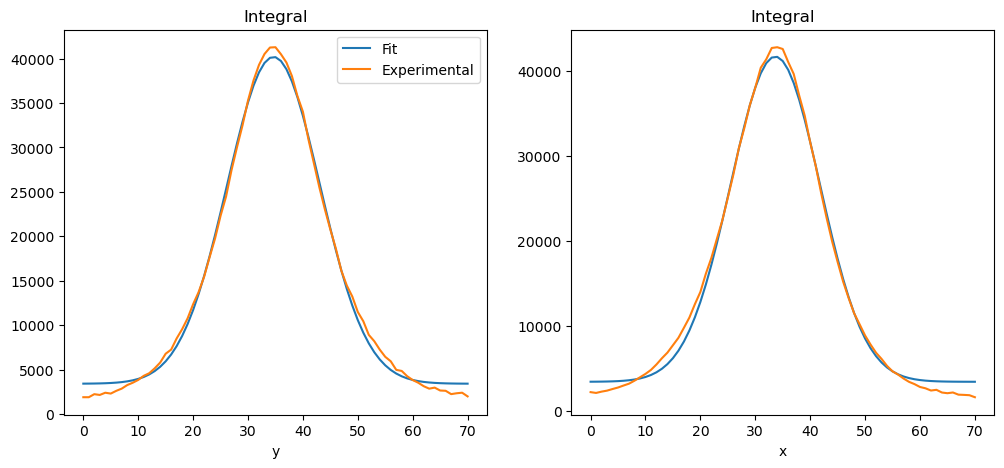

PyObject Text(0.5, 1.0, 'Integral')

In [70]:
img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(sum(image_reconstructed, dims=1)[1,:], label="Fit")
ax[1].plot(sum(data, dims=1)[1,:], label="Experimental")

ax[1].legend()

ax[2].plot(sum(image_reconstructed, dims=2))
ax[2].plot(sum(event.cam_4, dims=2))

ax[1].set_xlabel("y")
ax[1].set_title("Integral")

ax[2].set_xlabel("x")
ax[2].set_title("Integral")

# Fit 2 (Normal Fluctuations): 

In [15]:
log_likelihood_1 = let data = data
    
    params -> begin
    
        log_l = 0.0
        
        for pix_ind in CartesianIndices(data)
    
            x_edge = pix_ind.I[1] 
            y_edge = pix_ind.I[2] 

            pix_prediction::Float64 = cdf(Normal(params.μ_x,params.σ_x), x_edge) - cdf(Normal(params.μ_x,params.σ_x), x_edge - 1)
            pix_prediction *= cdf(Normal(params.μ_y,params.σ_y), y_edge) - cdf(Normal(params.μ_y,params.σ_y), y_edge - 1)

            pix_prediction = pix_prediction*params.i
            
#             log_l += log(pdf(Normal(pix_prediction, 1 + 5*sqrt(pix_prediction)), data[pix_ind]+1))
            
            log_l += log(pdf(truncated(Normal(pix_prediction, 1 + 5*sqrt(pix_prediction)), 0.0, Inf), data[pix_ind]+1))
            
        end
    
        return LogDVal(log_l)
        
    end
end

#3 (generic function with 1 method)

In [16]:
prior = NamedTupleDist(
    μ_x = 20 .. 50,
    μ_y = 20 .. 50,
    σ_x = 3 .. 20,
    σ_y = 3 .. 20,
    i = 280268 .. 1000268
    );

In [17]:
posterior = PosteriorDensity(log_likelihood_1, prior);
algorithm = MetropolisHastings()

nsamples = 10^4
nchains = 4

@time samples = bat_sample(posterior, (nsamples, nchains), algorithm,
        max_nsteps = 10^4, max_time = 20, 
    ).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 27.303568 seconds (6.42 M allocations: 378.795 MiB)


In [18]:
mode_params = mode(samples)[1]

(μ_x = 34.299933704080296, μ_y = 35.49882039088232, σ_x = 12.383766271084239, σ_y = 12.652036938437709, i = 1.0002674024432413e6)

In [19]:
image_reconstructed = zeros(Float64, size(data)...)

for pix_ind in CartesianIndices(image_reconstructed)
    
    x_edge = pix_ind.I[1] 
    y_edge = pix_ind.I[2] 

    pix_prediction::Float64 = cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge) - cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge - 1)
    pix_prediction *= cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge) - cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge - 1)

    pix_prediction = pix_prediction*mode_params.i
    image_reconstructed[pix_ind] = pix_prediction
end

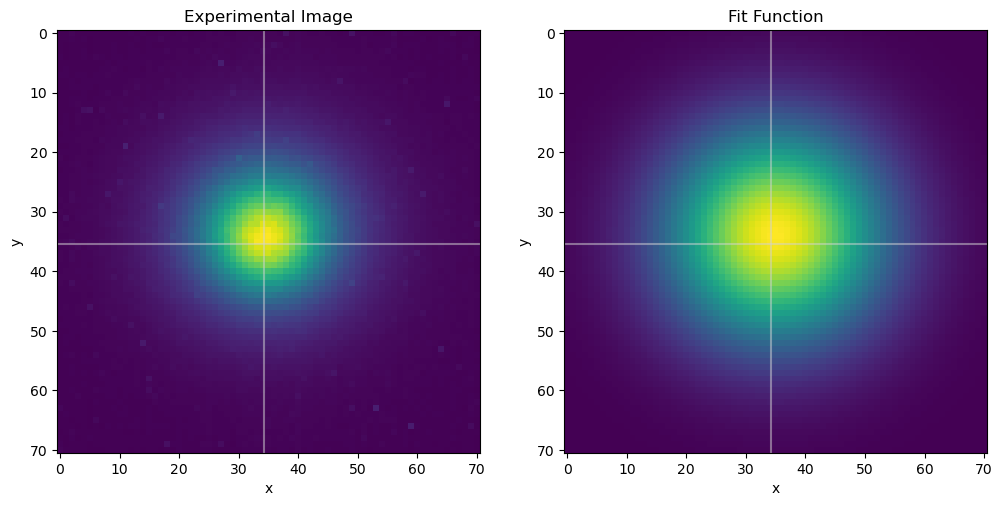

PyObject Text(0.5, 1.0, 'Fit Function')

In [20]:
img, (ax, ax2) = plt.subplots(1,2, figsize=(12,6))

ax.imshow(data)

ax.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax2.imshow(image_reconstructed)

ax2.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax2.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Experimental Image")

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Fit Function")

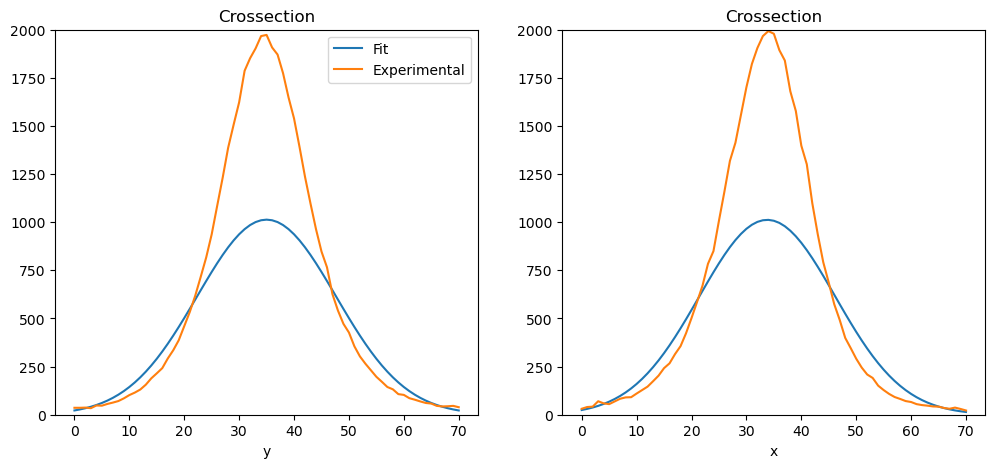

(0.0, 2000.0)

In [21]:
x = round(Int64, mode_params.μ_x)
y = round(Int64, mode_params.μ_y)

img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(image_reconstructed[x, :], label="Fit")
ax[1].plot(data[x, :], label="Experimental")
ax[1].legend()

ax[1].set_xlabel("y")
ax[1].set_title("Crossection")

ax[2].set_xlabel("x")
ax[2].set_title("Crossection")

ax[2].plot(image_reconstructed[:, y])
ax[2].plot(event.cam_4[:, y])

ax[1].set_ylim(0,2000)
ax[2].set_ylim(0,2000)

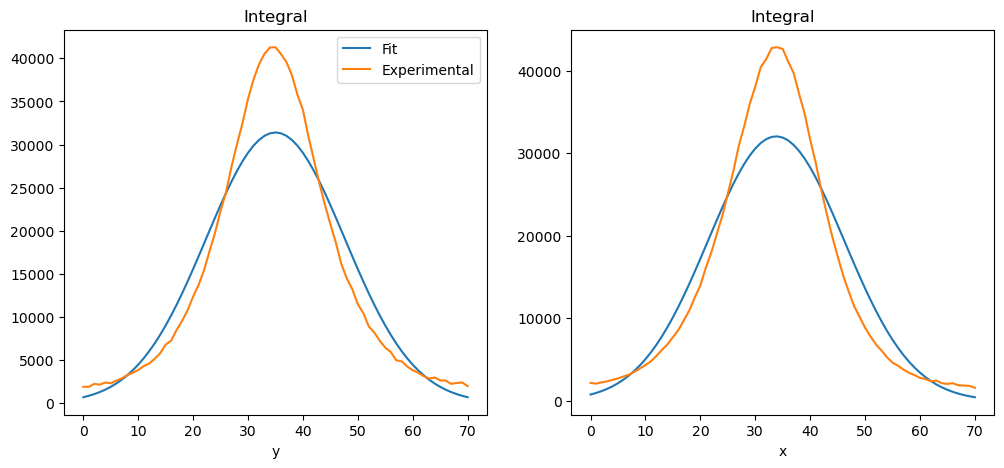

PyObject Text(0.5, 1.0, 'Integral')

In [22]:
img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(sum(image_reconstructed, dims=1)[1,:], label="Fit")
ax[1].plot(sum(data, dims=1)[1,:], label="Experimental")

ax[1].legend()

ax[2].plot(sum(image_reconstructed, dims=2))
ax[2].plot(sum(event.cam_4, dims=2))

ax[1].set_xlabel("y")
ax[1].set_title("Integral")

ax[2].set_xlabel("x")
ax[2].set_title("Integral")

# Fit 2-b (Normal Fluctuations + pedestal): 

In [23]:
log_likelihood_1 = let data = data
    
    params -> begin
    
        log_l = 0.0
        
        for pix_ind in CartesianIndices(data)
    
            x_edge = pix_ind.I[1] 
            y_edge = pix_ind.I[2] 

            pix_prediction::Float64 = cdf(Normal(params.μ_x,params.σ_x), x_edge) - cdf(Normal(params.μ_x,params.σ_x), x_edge - 1)
            pix_prediction *= cdf(Normal(params.μ_y,params.σ_y), y_edge) - cdf(Normal(params.μ_y,params.σ_y), y_edge - 1)

            pix_prediction = pix_prediction*params.i + params.b
            
#             log_l += log(pdf(Normal(pix_prediction, 1 + 5*sqrt(pix_prediction)), data[pix_ind]+1))
            
            log_l += log(pdf(truncated(Normal(pix_prediction, 1 + 2*sqrt(pix_prediction)), 0.0, Inf), data[pix_ind]+1))
            
        end
    
        return LogDVal(log_l)
        
    end
end

#5 (generic function with 1 method)

In [24]:
prior = NamedTupleDist(
    μ_x = 20 .. 50,
    μ_y = 20 .. 50,
    σ_x = 3 .. 20,
    σ_y = 3 .. 20,
    i = 280268 .. 1000268,
    b = 0 .. 100
    );

In [25]:
posterior = PosteriorDensity(log_likelihood_1, prior);
algorithm = MetropolisHastings()

nsamples = 10^4
nchains = 4

@time samples = bat_sample(posterior, (nsamples, nchains), algorithm,
        max_nsteps = 10^4, max_time = 20, 
    ).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 53.532264 seconds (6.88 M allocations: 406.439 MiB)


In [26]:
mode_params = mode(samples)[1]

(μ_x = 33.87224943957563, μ_y = 35.24744665583281, σ_x = 8.887862112409843, σ_y = 9.307914256328434, i = 848693.7460386055, b = 35.74788158701129)

In [27]:
image_reconstructed = zeros(Float64, size(data)...)

for pix_ind in CartesianIndices(image_reconstructed)
    
    x_edge = pix_ind.I[1] 
    y_edge = pix_ind.I[2] 

    pix_prediction::Float64 = cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge) - cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge - 1)
    pix_prediction *= cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge) - cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge - 1)

    pix_prediction = pix_prediction*mode_params.i + mode_params.b
    image_reconstructed[pix_ind] = pix_prediction
end

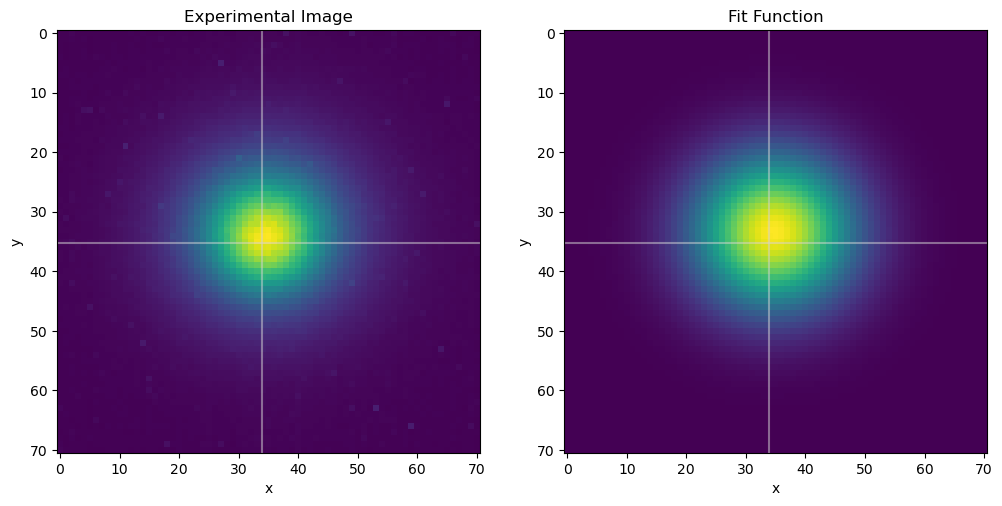

PyObject Text(0.5, 1.0, 'Fit Function')

In [28]:
img, (ax, ax2) = plt.subplots(1,2, figsize=(12,6))

ax.imshow(data)

ax.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax2.imshow(image_reconstructed)

ax2.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax2.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Experimental Image")

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Fit Function")

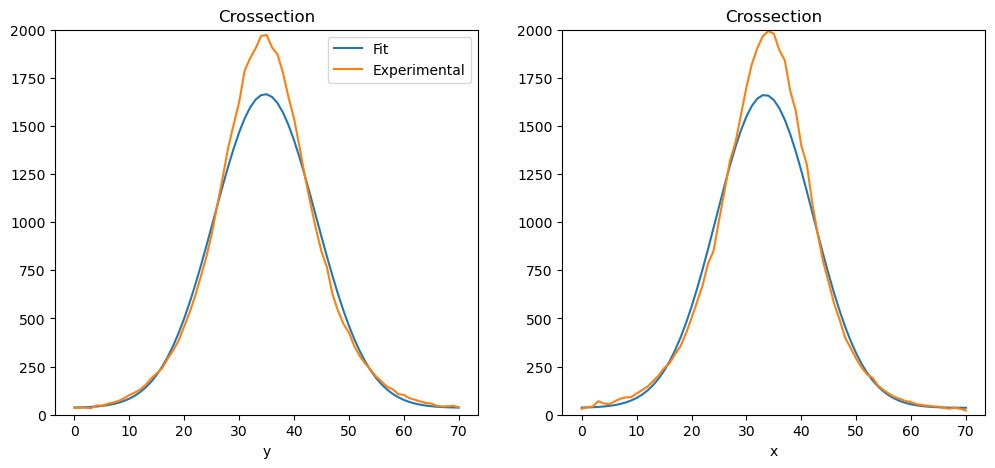

(0.0, 2000.0)

In [29]:
x = round(Int64, mode_params.μ_x)
y = round(Int64, mode_params.μ_y)

img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(image_reconstructed[x, :], label="Fit")
ax[1].plot(data[x, :], label="Experimental")
ax[1].legend()

ax[1].set_xlabel("y")
ax[1].set_title("Crossection")

ax[2].set_xlabel("x")
ax[2].set_title("Crossection")

ax[2].plot(image_reconstructed[:, y])
ax[2].plot(event.cam_4[:, y])

ax[1].set_ylim(0,2000)
ax[2].set_ylim(0,2000)

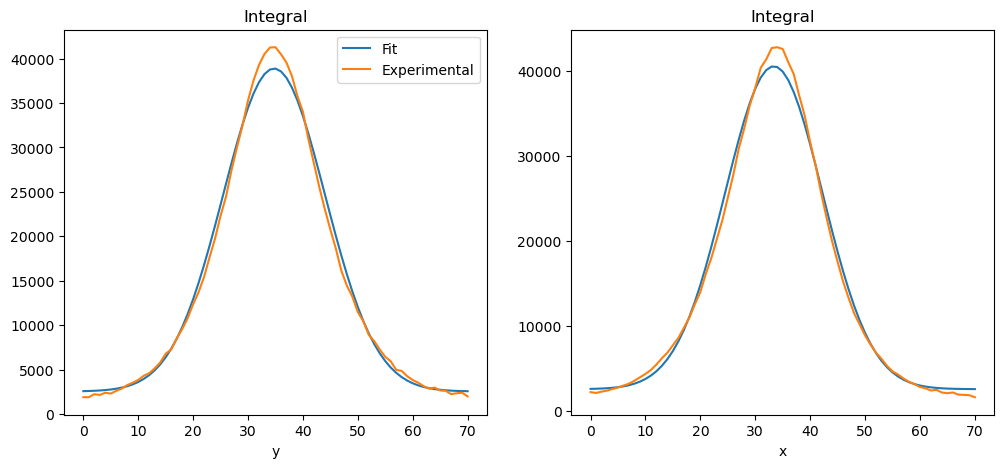

PyObject Text(0.5, 1.0, 'Integral')

In [30]:
img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(sum(image_reconstructed, dims=1)[1,:], label="Fit")
ax[1].plot(sum(data, dims=1)[1,:], label="Experimental")

ax[1].legend()

ax[2].plot(sum(image_reconstructed, dims=2))
ax[2].plot(sum(event.cam_4, dims=2))

ax[1].set_xlabel("y")
ax[1].set_title("Integral")

ax[2].set_xlabel("x")
ax[2].set_title("Integral")

# Fit 3 (Poisson Fluctuations): 

In [31]:
log_likelihood_2 = let data = data
    
    params -> begin
    
        log_l = 0.0
        
        for pix_ind in CartesianIndices(data)
    
            x_edge = pix_ind.I[1] 
            y_edge = pix_ind.I[2] 

            pix_prediction::Float64 = cdf(Normal(params.μ_x,params.σ_x), x_edge) - cdf(Normal(params.μ_x,params.σ_x), x_edge - 1)
            pix_prediction *= cdf(Normal(params.μ_y,params.σ_y), y_edge) - cdf(Normal(params.μ_y,params.σ_y), y_edge - 1)

            pix_prediction = pix_prediction*params.i
            
#             log_l += log(pdf(truncated(Poisson(pix_prediction+1), 0, 5000), data[pix_ind]+1))
            log_l += log(pdf(Poisson(pix_prediction+2), data[pix_ind]+1))
        end
        return LogDVal(log_l)
        
    end
end

#7 (generic function with 1 method)

In [32]:
prior = NamedTupleDist(
    μ_x = 32 .. 37,
    μ_y = 32 .. 37,
    σ_x = 3 .. 20,
    σ_y = 3 .. 20,
    i = 1 .. 2^20
    );

In [33]:
posterior = PosteriorDensity(log_likelihood_2, prior);
algorithm = MetropolisHastings()

nsamples = 10^4
nchains = 4

@time samples = bat_sample(posterior, (nsamples, nchains), algorithm,
        max_nsteps = 10^4, max_time = 20, 
    ).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 32.815988 seconds (6.45 M allocations: 372.412 MiB, 0.33% gc time)


In [34]:
mode_params = mode(samples)[1]

(μ_x = 33.86497791889501, μ_y = 35.35135763599442, σ_x = 11.182426292391858, σ_y = 11.592342437850613, i = 1.0115240311716914e6)

In [35]:
image_reconstructed = zeros(Float64, size(data)...)

for pix_ind in CartesianIndices(image_reconstructed)
    
    x_edge = pix_ind.I[1] 
    y_edge = pix_ind.I[2] 

    pix_prediction::Float64 = cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge) - cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge - 1)
    pix_prediction *= cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge) - cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge - 1)

    pix_prediction = pix_prediction*mode_params.i
    image_reconstructed[pix_ind] = pix_prediction
end

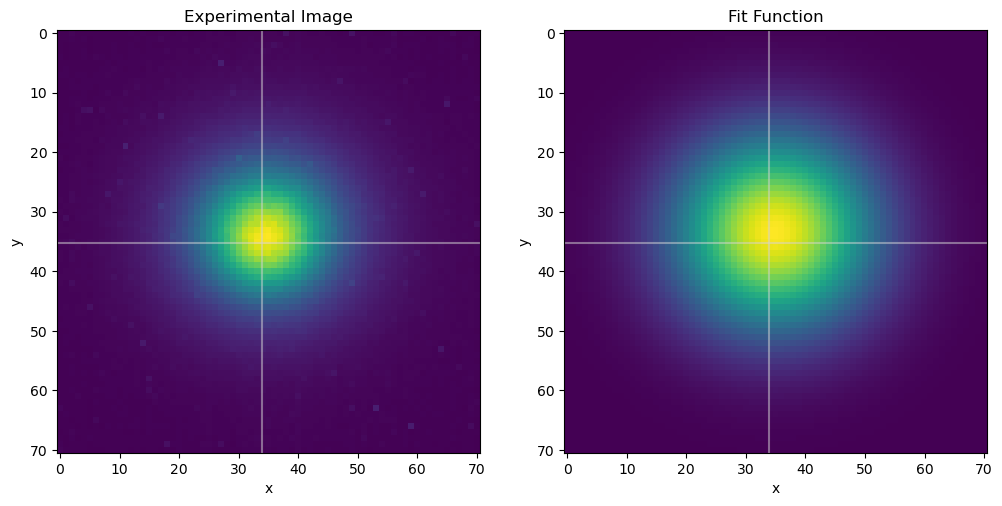

PyObject Text(0.5, 1.0, 'Fit Function')

In [36]:
img, (ax, ax2) = plt.subplots(1,2, figsize=(12,6))

ax.imshow(data)

ax.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax2.imshow(image_reconstructed)

ax2.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax2.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Experimental Image")

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Fit Function")

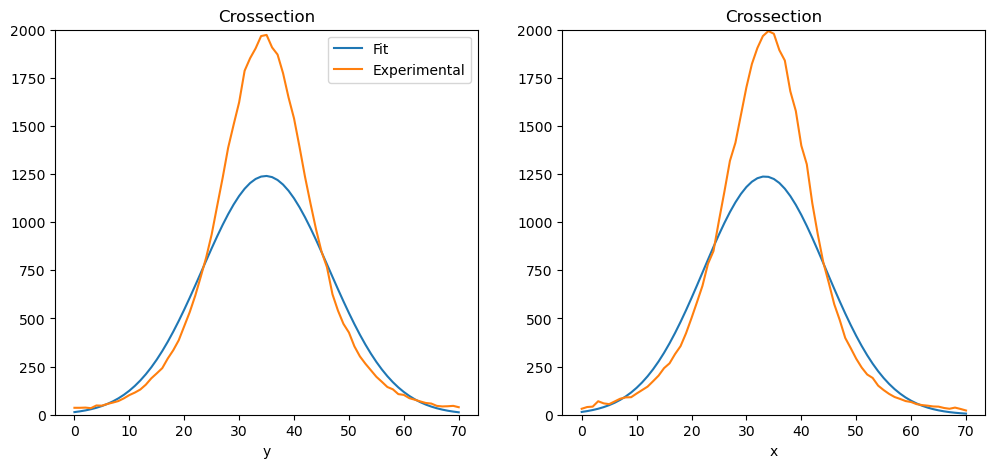

(0.0, 2000.0)

In [37]:
x = round(Int64, mode_params.μ_x)
y = round(Int64, mode_params.μ_y)

img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(image_reconstructed[x, :], label="Fit")
ax[1].plot(data[x, :], label="Experimental")
ax[1].legend()

ax[1].set_xlabel("y")
ax[1].set_title("Crossection")

ax[2].set_xlabel("x")
ax[2].set_title("Crossection")

ax[2].plot(image_reconstructed[:, y])
ax[2].plot(event.cam_4[:, y])

ax[1].set_ylim(0,2000)
ax[2].set_ylim(0,2000)

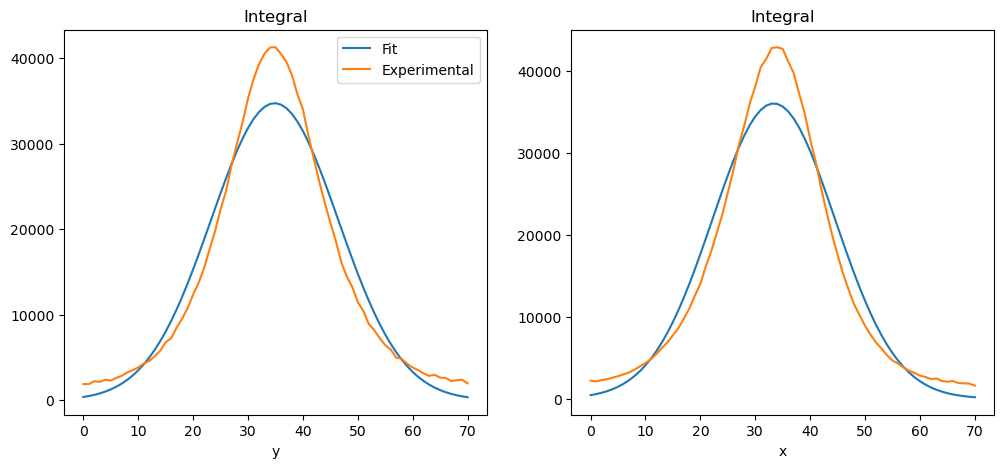

PyObject Text(0.5, 1.0, 'Integral')

In [38]:
img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(sum(image_reconstructed, dims=1)[1,:], label="Fit")
ax[1].plot(sum(data, dims=1)[1,:], label="Experimental")

ax[1].legend()

ax[2].plot(sum(image_reconstructed, dims=2))
ax[2].plot(sum(event.cam_4, dims=2))

ax[1].set_xlabel("y")
ax[1].set_title("Integral")

ax[2].set_xlabel("x")
ax[2].set_title("Integral")

# Fit 3-b (Poisson Fluctuations + pedestal): 

In [39]:
log_likelihood_2 = let data = data
    
    params -> begin
    
        log_l = 0.0
        
        for pix_ind in CartesianIndices(data)
    
            x_edge = pix_ind.I[1] 
            y_edge = pix_ind.I[2] 

            pix_prediction::Float64 = cdf(Normal(params.μ_x,params.σ_x), x_edge) - cdf(Normal(params.μ_x,params.σ_x), x_edge - 1)
            pix_prediction *= cdf(Normal(params.μ_y,params.σ_y), y_edge) - cdf(Normal(params.μ_y,params.σ_y), y_edge - 1)

            pix_prediction = pix_prediction*params.i + params.b
            
#             log_l += log(pdf(truncated(Poisson(pix_prediction+1), 0, 5000), data[pix_ind]+1))
            log_l += log(pdf(Poisson(pix_prediction), data[pix_ind]+1))
        end
        return LogDVal(log_l)
        
    end
end

#9 (generic function with 1 method)

In [40]:
prior = NamedTupleDist(
    μ_x = 32 .. 37,
    μ_y = 32 .. 37,
    σ_x = 3 .. 20,
    σ_y = 3 .. 20,
    i = 1 .. 2^20,
    b = 0 .. 100
    );

In [41]:
posterior = PosteriorDensity(log_likelihood_2, prior);
algorithm = MetropolisHastings()

nsamples = 10^4
nchains = 4

@time samples = bat_sample(posterior, (nsamples, nchains), algorithm,
        max_nsteps = 10^4, max_time = 20, 
    ).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 46.211789 seconds (6.14 M allocations: 369.378 MiB)


In [42]:
mode_params = mode(samples)[1]

(μ_x = 33.8772689964895, μ_y = 35.24217788850361, σ_x = 8.930108532976297, σ_y = 9.355013448609538, i = 849728.0635978652, b = 35.72886822212223)

In [43]:
image_reconstructed = zeros(Float64, size(data)...)

for pix_ind in CartesianIndices(image_reconstructed)
    
    x_edge = pix_ind.I[1] 
    y_edge = pix_ind.I[2] 

    pix_prediction::Float64 = cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge) - cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge - 1)
    pix_prediction *= cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge) - cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge - 1)

    pix_prediction = pix_prediction*mode_params.i + mode_params.b
    image_reconstructed[pix_ind] = pix_prediction
end

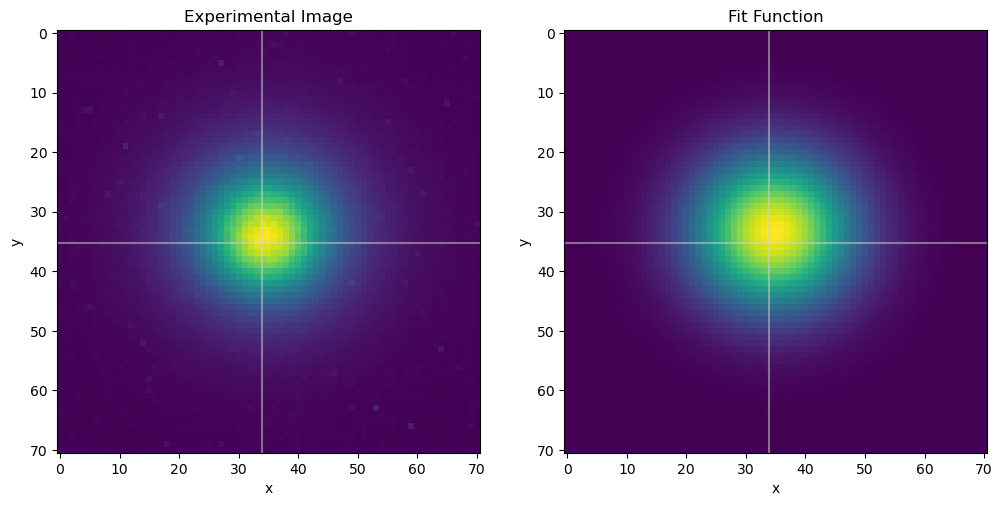

PyObject Text(0.5, 1.0, 'Fit Function')

In [44]:
img, (ax, ax2) = plt.subplots(1,2, figsize=(12,6))

ax.imshow(data)

ax.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax2.imshow(image_reconstructed)

ax2.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax2.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Experimental Image")

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Fit Function")

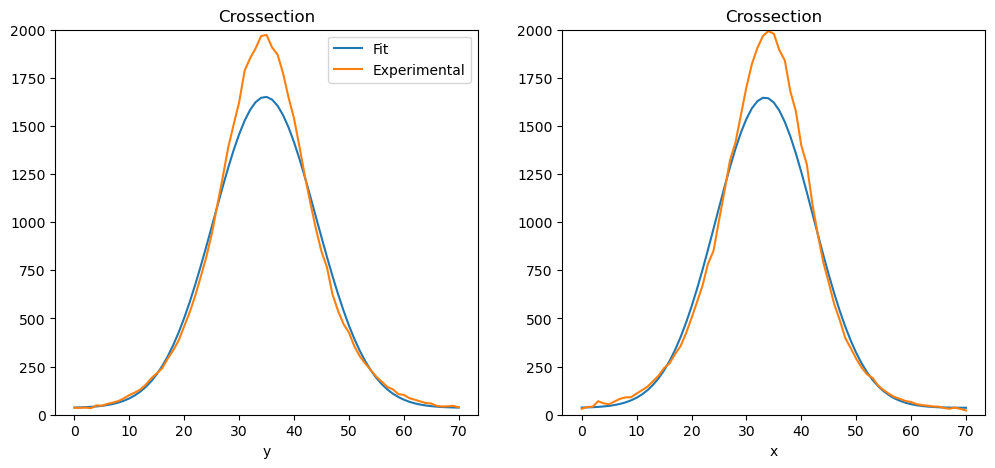

(0.0, 2000.0)

In [45]:
x = round(Int64, mode_params.μ_x)
y = round(Int64, mode_params.μ_y)

img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(image_reconstructed[x, :], label="Fit")
ax[1].plot(data[x, :], label="Experimental")
ax[1].legend()

ax[1].set_xlabel("y")
ax[1].set_title("Crossection")

ax[2].set_xlabel("x")
ax[2].set_title("Crossection")

ax[2].plot(image_reconstructed[:, y])
ax[2].plot(event.cam_4[:, y])

ax[1].set_ylim(0,2000)
ax[2].set_ylim(0,2000)

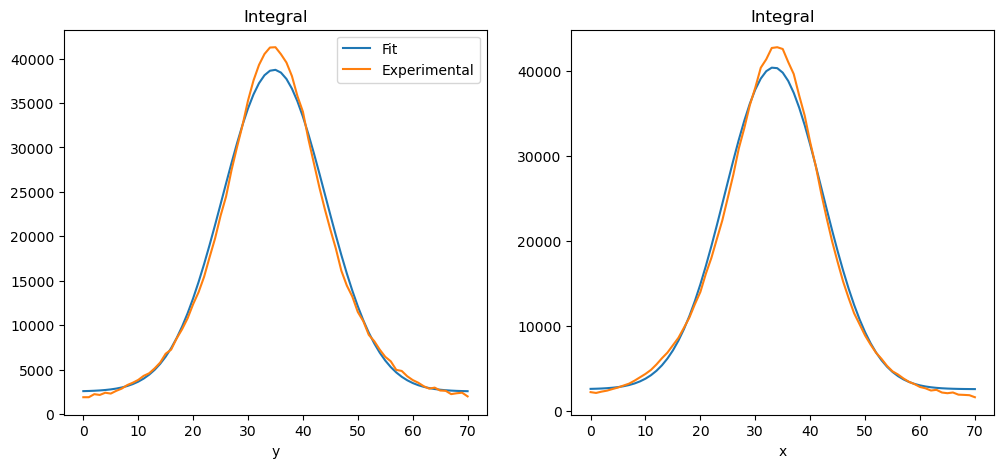

PyObject Text(0.5, 1.0, 'Integral')

In [46]:
img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(sum(image_reconstructed, dims=1)[1,:], label="Fit")
ax[1].plot(sum(data, dims=1)[1,:], label="Experimental")

ax[1].legend()

ax[2].plot(sum(image_reconstructed, dims=2))
ax[2].plot(sum(event.cam_4, dims=2))

ax[1].set_xlabel("y")
ax[1].set_title("Integral")

ax[2].set_xlabel("x")
ax[2].set_title("Integral")

# Fit 4 (+ background): 

In [47]:
log_likelihood_3 = let data = data,  c = conv_matrices.cam_4
    
    params -> begin
        
        image_matrix = zeros(Float64, size(data)...)
        
        max_pred_amp::Int64 = size(c)[2]-1
        log_l::Float64 = 0.0
        
        for pix_ind in CartesianIndices(image_matrix)
    
            x_edge = pix_ind.I[1] 
            y_edge = pix_ind.I[2] 

            pix_prediction::Float64 = cdf(Normal(params.μ_x,params.σ_x), x_edge) - cdf(Normal(params.μ_x,params.σ_x), x_edge - 1)
            pix_prediction *= cdf(Normal(params.μ_y,params.σ_y), y_edge) - cdf(Normal(params.μ_y,params.σ_y), y_edge - 1)

            pix_prediction = pix_prediction*params.i
            
            cv_index = floor(Int64, pix_prediction)

            if cv_index > max_pred_amp
                cv_index = max_pred_amp
            end

            log_l += log(c[data[pix_ind]+1, cv_index+1])
            
        end

    
        return LogDVal(log_l)
        
    end
end

#11 (generic function with 1 method)

In [48]:
prior = NamedTupleDist(
    μ_x = 20 .. 50,
    μ_y = 20 .. 50,
    σ_x = 3 .. 20,
    σ_y = 3 .. 20,
    i = 1 .. 2^20
    );

In [49]:
posterior = PosteriorDensity(log_likelihood_3, prior);
algorithm = MetropolisHastings()

nsamples = 10^4
nchains = 4

@time samples = bat_sample(posterior, (nsamples, nchains), algorithm,
        max_nsteps = 10^4, max_time = 20, 
    ).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 32.470183 seconds (6.49 M allocations: 3.933 GiB, 4.32% gc time)


In [50]:
mode_params = mode(samples)[1]

(μ_x = 33.64998235451169, μ_y = 35.390262014803945, σ_x = 10.633150991199129, σ_y = 11.134575906670387, i = 833409.8593366633)

In [51]:
image_reconstructed = zeros(Float64, size(data)...)

for pix_ind in CartesianIndices(image_reconstructed)
    
    x_edge = pix_ind.I[1] 
    y_edge = pix_ind.I[2] 

    pix_prediction::Float64 = cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge) - cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge - 1)
    pix_prediction *= cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge) - cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge - 1)

    pix_prediction = pix_prediction*mode_params.i
    image_reconstructed[pix_ind] = pix_prediction
end

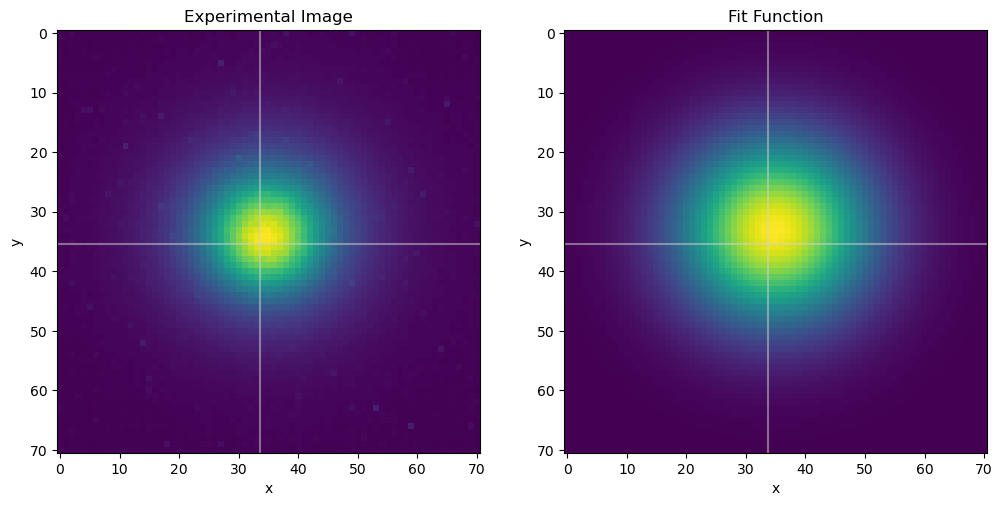

PyObject Text(0.5, 1.0, 'Fit Function')

In [52]:
img, (ax, ax2) = plt.subplots(1,2, figsize=(12,6))

ax.imshow(data)

ax.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax2.imshow(image_reconstructed)

ax2.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax2.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Experimental Image")

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Fit Function")

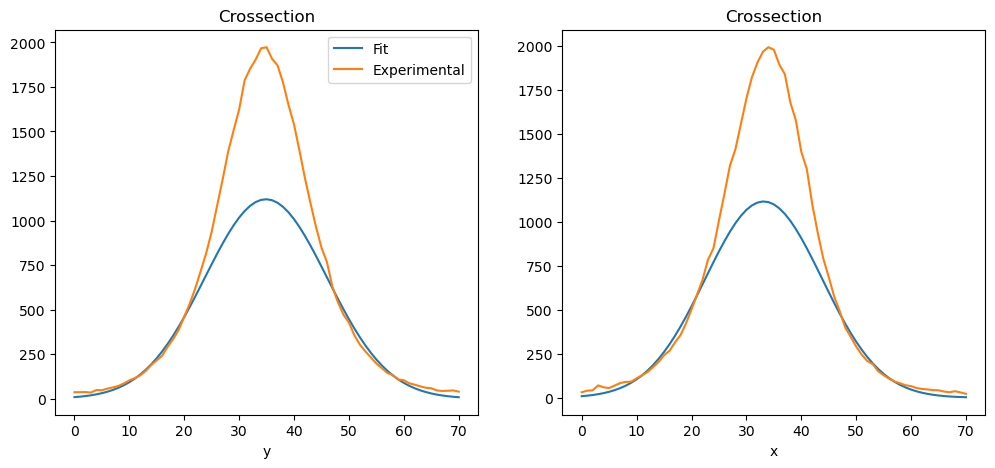

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f81e3116d30>

In [53]:
x = round(Int64, mode_params.μ_x)
y = round(Int64, mode_params.μ_y)

img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(image_reconstructed[x, :], label="Fit")
ax[1].plot(data[x, :], label="Experimental")
ax[1].legend()

ax[1].set_xlabel("y")
ax[1].set_title("Crossection")

ax[2].set_xlabel("x")
ax[2].set_title("Crossection")

ax[2].plot(image_reconstructed[:, y])
ax[2].plot(event.cam_4[:, y])

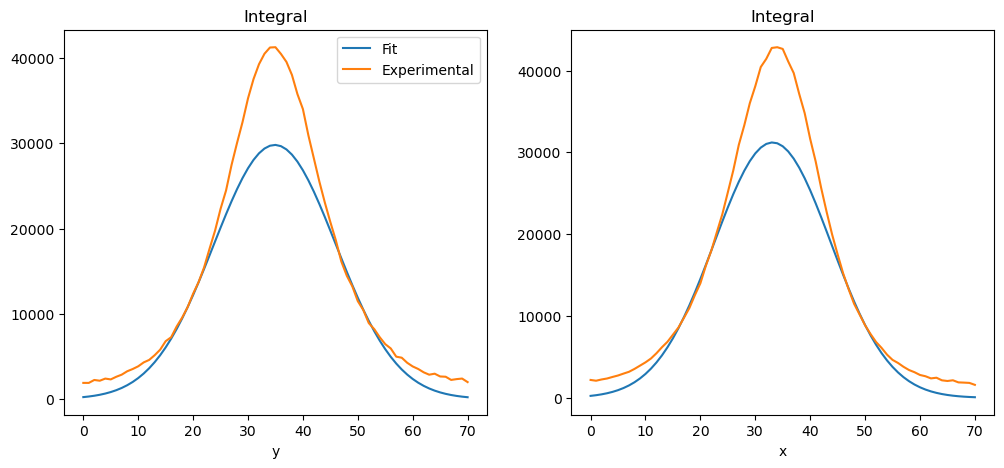

PyObject Text(0.5, 1.0, 'Integral')

In [54]:
img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(sum(image_reconstructed, dims=1)[1,:], label="Fit")
ax[1].plot(sum(data, dims=1)[1,:], label="Experimental")

ax[1].legend()

ax[2].plot(sum(image_reconstructed, dims=2))
ax[2].plot(sum(event.cam_4, dims=2))

ax[1].set_xlabel("y")
ax[1].set_title("Integral")

ax[2].set_xlabel("x")
ax[2].set_title("Integral")

# Fit 4-b (+ background + pedestal): 

In [55]:
log_likelihood_3 = let data = data,  c = conv_matrices.cam_4
    
    params -> begin
        
        image_matrix = zeros(Float64, size(data)...)
        
        max_pred_amp::Int64 = size(c)[2]-1
        log_l::Float64 = 0.0
        
        for pix_ind in CartesianIndices(image_matrix)
    
            x_edge = pix_ind.I[1] 
            y_edge = pix_ind.I[2] 

            pix_prediction::Float64 = cdf(Normal(params.μ_x,params.σ_x), x_edge) - cdf(Normal(params.μ_x,params.σ_x), x_edge - 1)
            pix_prediction *= cdf(Normal(params.μ_y,params.σ_y), y_edge) - cdf(Normal(params.μ_y,params.σ_y), y_edge - 1)

            pix_prediction = pix_prediction*params.i + params.b
            
            cv_index = floor(Int64, pix_prediction)

            if cv_index > max_pred_amp
                cv_index = max_pred_amp
            end

            log_l += log(c[data[pix_ind]+1, cv_index+1])
            
        end

    
        return LogDVal(log_l)
        
    end
end

#13 (generic function with 1 method)

In [56]:
prior = NamedTupleDist(
    μ_x = 20 .. 50,
    μ_y = 20 .. 50,
    σ_x = 3 .. 20,
    σ_y = 3 .. 20,
    i = 1 .. 2^20,
    b = 0 .. 100
    );

In [57]:
posterior = PosteriorDensity(log_likelihood_3, prior);
algorithm = MetropolisHastings()

nsamples = 10^4
nchains = 4

@time samples = bat_sample(posterior, (nsamples, nchains), algorithm,
        max_nsteps = 10^4, max_time = 20, 
    ).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 52.040392 seconds (7.23 M allocations: 6.318 GiB, 8.24% gc time)


In [58]:
mode_params = mode(samples)[1]

(μ_x = 33.82546331470186, μ_y = 35.26028410235825, σ_x = 9.046556656383654, σ_y = 9.464857409251955, i = 847363.7679716041, b = 18.750714745399243)

In [59]:
image_reconstructed = zeros(Float64, size(data)...)

for pix_ind in CartesianIndices(image_reconstructed)
    
    x_edge = pix_ind.I[1] 
    y_edge = pix_ind.I[2] 

    pix_prediction::Float64 = cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge) - cdf(Normal(mode_params.μ_x,mode_params.σ_x), x_edge - 1)
    pix_prediction *= cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge) - cdf(Normal(mode_params.μ_y,mode_params.σ_y), y_edge - 1)

    pix_prediction = pix_prediction*mode_params.i + mode_params.b
    image_reconstructed[pix_ind] = pix_prediction
end

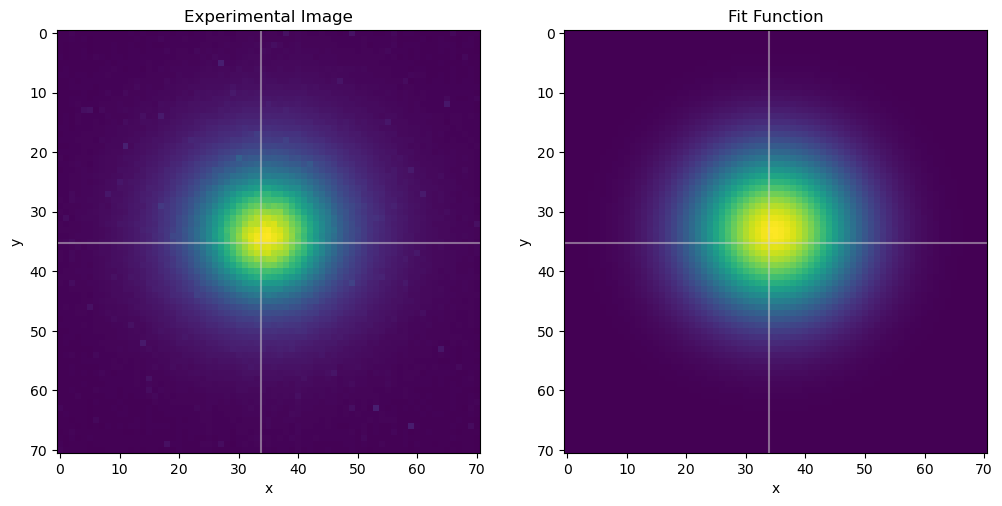

PyObject Text(0.5, 1.0, 'Fit Function')

In [60]:
img, (ax, ax2) = plt.subplots(1,2, figsize=(12,6))

ax.imshow(data)

ax.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax2.imshow(image_reconstructed)

ax2.axvline(mode_params.μ_x, linestyle="-", color="lightgray", alpha=0.5)
ax2.axhline(mode_params.μ_y, linestyle="-", color="lightgray", alpha=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Experimental Image")

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Fit Function")

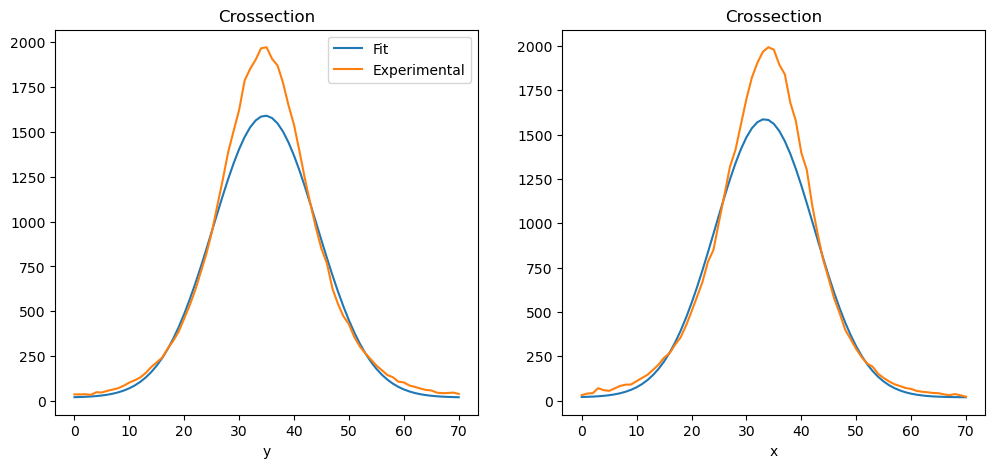

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8187b31940>

In [61]:
x = round(Int64, mode_params.μ_x)
y = round(Int64, mode_params.μ_y)

img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(image_reconstructed[x, :], label="Fit")
ax[1].plot(data[x, :], label="Experimental")
ax[1].legend()

ax[1].set_xlabel("y")
ax[1].set_title("Crossection")

ax[2].set_xlabel("x")
ax[2].set_title("Crossection")

ax[2].plot(image_reconstructed[:, y])
ax[2].plot(event.cam_4[:, y])

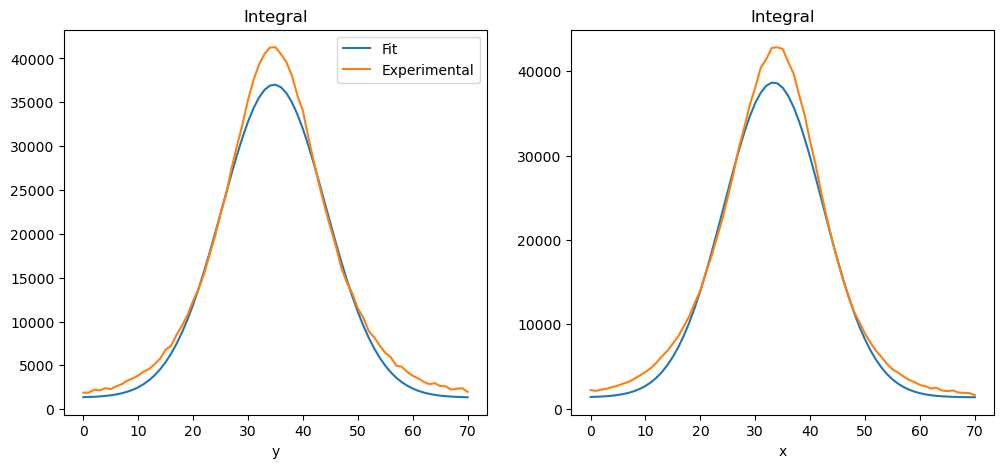

PyObject Text(0.5, 1.0, 'Integral')

In [62]:
img, ax = plt.subplots(1,2, figsize=(12,5))

ax[1].plot(sum(image_reconstructed, dims=1)[1,:], label="Fit")
ax[1].plot(sum(data, dims=1)[1,:], label="Experimental")

ax[1].legend()

ax[2].plot(sum(image_reconstructed, dims=2))
ax[2].plot(sum(event.cam_4, dims=2))

ax[1].set_xlabel("y")
ax[1].set_title("Integral")

ax[2].set_xlabel("x")
ax[2].set_title("Integral")